# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [1]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from time import time
from sklearn.inspection import permutation_importance
from scipy import stats
import math

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import cross_val_predict

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import multiprocessing

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

## Read in formatted data

In [2]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Delete unneeded columns
We currently include data from all sensors (even incomplete ones)

In [3]:
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

### Add a random variable (to compare performance of other variables against)

In [4]:
rng = np.random.RandomState(seed=42)
data['random'] = np.random.random(size=len(data))
data["random_cat"] = rng.randint(3, size=data.shape[0])

## Prepare data for modelling 
### Split into predictor/predictand variables

In [5]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Store the (non Sin/Cos) time columns and then remove them
Need them later to segment the results by hour of the day

In [6]:
data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num']]
Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [7]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor',RandomForestRegressor(random_state = 1, n_jobs = 32)]])
# xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',XGBRegressor(random_state=1, n_jobs = 200)]])
# et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (n_estimators = 500, random_state = 1, n_jobs = 32)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [8]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [9]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$'}
#                      'nosubtyes':'buildings_|furniture_|landmarks_|sensor_id'}
#                      'time_and_weather':'buildings|furniture|landmarks|h_|lights|avg_n_floors|betweenness',
#                       'just_location_features':'buildings$|furniture$|landmarks$|school_holiday|public_holiday|Temp|Humidity|Pressure|Rain|WindSpeed|Sin|Cos'}

### Loop through each combination of the models, and the variables to include in the modelling

In [10]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

# models_dict = {"linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline, 
#                "rf_regressor":rf_model_pipeline, "et_regressor":et_model_pipeline}
models_dict = {"rf_regressor":rf_model_pipeline}
for model_name,model in models_dict.items():
    for regex_name, regex in column_regex_dict.items():
        # Run the model: return the estimators and a dataframe containing evaluation metrics
        estimators, error_metrics_df, feature_list, predictions = run_model_with_cv_and_predict(
            model, model_name, error_metrics, cv_parameters, Xfull, Yfull, regex_name, regex) 
        # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
        error_metric_scores = error_metric_scores.append(error_metrics_df)
        
        # Create dataframe of feature importances (no feature importances for linear regression)
        if model_name != 'linear_regressor':
            feature_importances = pd.DataFrame(index =[feature_list])
            for idx,estimator in enumerate(estimators):
                    feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
            feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

Running rf_regressor model, variables include withsubtypes
Ran in 11 minutes


### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

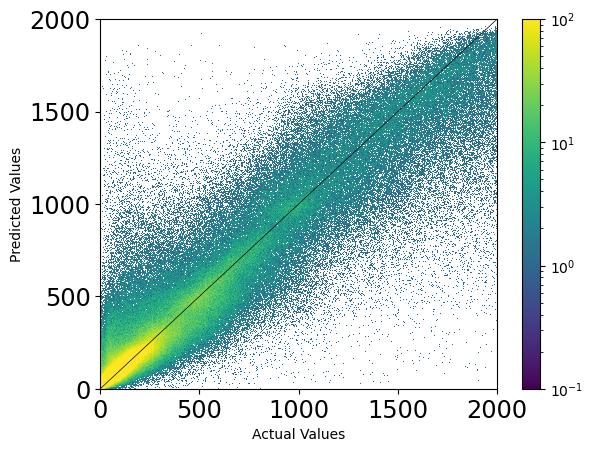

In [11]:
fig, ax = plt.subplots()
using_datashader(ax, Yfull, predictions, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
ax.xaxis.set_tick_params(labelsize='xx-large')
ax.yaxis.set_tick_params(labelsize='xx-large')
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000]);

### Print the accuracy scores

In [12]:
error_metric_scores

,mae,r2,rmse
rf_regressor_withsubtypes,72.9,0.88,148.29


### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [16]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

#### Get the most important top 10 columns for each estimator

In [146]:
# important_columns=pd.DataFrame()
# for column in feature_importances_df.columns[1:]:
#     this_col = feature_importances_df[['Variable', column]]
#     important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()[0:10]
# important_columns    

## Choose the best model 

Random Forest was the best performing model

## Fit the final model
For this, we use all of the data

In [12]:
# 1
rf_model_pipeline1 = Pipeline(steps=[['scaler',StandardScaler()],
                                    ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 32)]])
rf_model_pipeline1.fit(Xfull, Yfull)
# 2
rf_model_pipeline2 = Pipeline(steps=[['scaler',StandardScaler()],
                                    ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 2, n_jobs = 32)]])
rf_model_pipeline2.fit(Xfull, Yfull);
# 3
rf_model_pipeline3 = Pipeline(steps=[['scaler',StandardScaler()],
                                    ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 3, n_jobs = 32)]])
rf_model_pipeline3.fit(Xfull, Yfull);

### Find Gini impurity feature importances
Gini feature importance (or mean decrease in impurity) counts the number of times a feature is used to split a node, weighted by the number of samples it splits.

In [13]:
def find_gini_importance(model):
    # Get numerical feature importances
    rf_importances = list(model.feature_importances_)
    rf_feature_importances = pd.DataFrame({'feature': Xfull.columns,'importance':rf_importances})      
    rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = True)
    # Get just the features that scored more highly than a random feature
    rf_feature_importances_overrandom = rf_feature_importances[rf_feature_importances['importance']>rf_feature_importances.query("feature=='random'")["importance"].values[0]]
    return rf_feature_importances
    
gi_1 = find_gini_importance(rf_model_pipeline1['rf_regressor'])    
gi_2 = find_gini_importance(rf_model_pipeline2['rf_regressor'])   
gi_3 = find_gini_importance(rf_model_pipeline3['rf_regressor'])   

### Find the permutation importances

In [14]:
# This is based on analysis of how the score changes when the feature is not available
# Thus we need to chose the accuracy score to use
def find_permutation_importance(model, Xfull, Yfull, n_iter):
    # instantiate permuter object
    permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', cv='prefit', n_iter=n_iter)
    permuter.fit(Xfull.values, Yfull)
    # Create a dataframe containing the mean results (and std)
    pi_meanvalues_df = pd.DataFrame({'feature':Xfull.columns,
                  'importance':permuter.feature_importances_,
                  'Feature_importance_std': permuter.feature_importances_std_}).sort_values('importance', ascending = True)
    # Get the raw results for each permutation, and store as a dataframe
    pi_raw_results = permuter.results_  
    raw_importances = pd.DataFrame({'feature_list':list(Xfull.columns)})
    for num,results in enumerate(permuter.results_):
        raw_importances[num] = results
    raw_importances =raw_importances.sort_values(by=0, ascending=False)
    raw_importances.reset_index(drop = True, inplace=True)
    
    # Get just the features that scored more highly than a random feature
    return pi_meanvalues_df, raw_importances

pi_1, pi_1_raw = find_permutation_importance(rf_model_pipeline1['rf_regressor'], Xfull, Yfull, n_iter=10)    
# pi_2 = find_permutation_importance(rf_model_pipeline2['rf_regressor'], Xfull, Yfull)   
# pi_3 = find_permutation_importance(rf_model_pipeline3['rf_regressor'], Xfull, Yfull)   

In [122]:
# PLot boxplot showing spread in the permutation importance values
ax = pi_1_raw.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Plot and compare feature importances

In [51]:
# cardinality_df = pd.DataFrame({'feature':Xfull.columns, 'n_features':Xfull.nunique()})
# cardinality_df = cardinality_df.merge(pi_1, on='feature', how='outer')
# cardinality_df = cardinality_df.drop([0,1,2,4, 45])
# plt.scatter(cardinality_df['n_features'], cardinality_df['importance'])
# # plt.scatter(cardinality_df[:-2]['n_features'], cardinality_df[:-2]['importance'])
# # cardinality_df

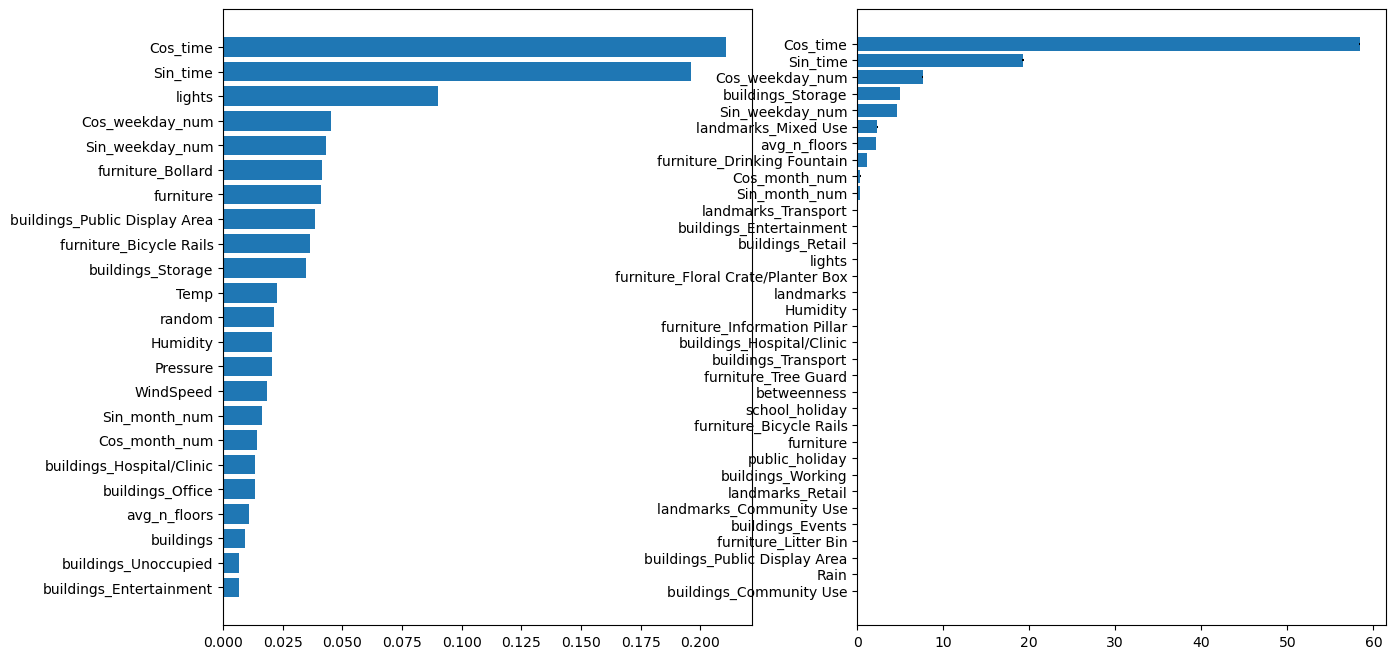

In [138]:
def plot_compare_importances(gini_importances, perm_importances, above_random_cat = False):
    
    if above_random_cat == 'random_num':
        gini_importances = gini_importances[gini_importances['importance']>gini_importances.query("feature=='random'")["importance"].values[0]]
        perm_importances = perm_importances[perm_importances['importance']>perm_importances.query("feature=='random'")["importance"].values[0]]
    elif above_random_cat == 'random_cat':
        gini_importances = gini_importances[gini_importances['importance']>gini_importances.query("feature=='random_cat'")["importance"].values[0]]
        perm_importances = perm_importances[perm_importances['importance']>perm_importances.query("feature=='random_cat'")["importance"].values[0]]
        
    fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
    axs[0].barh(range(len(gini_importances['importance'])), gini_importances["importance"])
    axs[0].set_yticks(range(len(gini_importances["feature"])))
    _ = axs[0].set_yticklabels(np.array(gini_importances["feature"]))
    axs[0].set_title('Gini importance')

    axs[1].barh(range(len(perm_importances['importance'])),
             perm_importances['importance'],
             xerr=perm_importances['Feature_importance_std'])
    axs[1].set_yticks(range(len(perm_importances['importance'])))
    _ = axs[1].set_yticklabels(perm_importances['feature'])  
    axs[1].set_title('Permutation importance')
    
plot_compare_importances(gi_1, pi_1, above_random_cat='random_cat')    

### Plots!?

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

# axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
# axs[0].invert_yaxis()
# plt.rcParams.update({'font.size': 5})
# axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
# axs[0].set_xlabel('Importance', fontsize = 12)
# axs[0].set_ylabel('Feature', fontsize = 12)
# axs[0].xaxis.set_tick_params(labelsize='xx-large')
# axs[0].yaxis.set_tick_params(labelsize='xx-large')

# using_datashader(axs[1],Yfull, rf_predictions, 'linear')
# axs[1].plot([Y_test.min(), Yfull.max()], [Yfull.min(), Y_test.max()], c='k', lw=0.5)
# axs[1].set_ylabel("Predicted Values", size=10)
# axs[1].set_xlabel("Actual Values", size=10)
# axs[1].xaxis.set_tick_params(labelsize='xx-large')
# axs[1].yaxis.set_tick_params(labelsize='xx-large')
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000])

# using_datashader(axs[2], Y_test, rf_predictions, 'log')
# axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
# axs[2].set_ylabel("Predicted Values", size=10)
# axs[2].set_xlabel("Actual Values", size=10)
# axs[2].xaxis.set_tick_params(labelsize='xx-large')
# axs[2].yaxis.set_tick_params(labelsize='xx-large')
# axs[2].set_xlim([0, 2000])
# axs[2].set_ylim([0, 2000])

# plt.show()